✅ What this notebook does
- Loads all metrics & models from previous notebooks.

- Evaluates on held-out test set, recalculating metrics where necessary.

- Applies selection strategy:
    - Primary: PR AUC
    - Secondary: Recall
    - Constraint: Precision ≥ 0.5

- Automatically selects best model and saves:

- Model: models/best_model.pkl or .h5

- Metadata: artifacts/best_model.json

- Converts your results dictionary into a pandas DataFrame and prints.
    
- Plots ROC & PR curves for all candidate models.

- Picks the top 2 models by PR AUC from previous validation metrics.

- Runs Optuna tuning (20 trials each) to maximize PR AUC.

- Evaluates the tuned models on the test set.

- Automatically selects the best model based on PR AUC.

- Saves the best model (best_model.pkl) and its metadata (best_model.json).

- Prints all metrics on the test set for the final selected model.

In [2]:
# Imports
import joblib
import json
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, precision_recall_curve, roc_curve, auc

# TensorFlow for loading MLP / Autoencoder
from tensorflow.keras.models import load_model

import warnings
warnings.filterwarnings("ignore")

In [3]:
# -----------------------------
# Helper function for PR AUC
# -----------------------------
def compute_pr_auc(y_true, y_scores):
    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    return auc(recall, precision)

In [4]:
# -----------------------------
# Ensure folders exist
# -----------------------------
ARTIFACTS_DIR = Path("artifacts")
MODELS_DIR = Path("models")


In [5]:
# -----------------------------
# Load test data
# -----------------------------
data = joblib.load(ARTIFACTS_DIR / "data_splits.pkl")
X_test, y_test = data["X_test"], data["y_test"]


## Load candidate models and metrics

In [7]:
model_files = {
    "logreg": ("logreg.pkl", "metrics_logreg.pkl"),
    "random_forest": ("random_forest.pkl", "metrics_rf.pkl"),
    "xgboost": ("xgboost.pkl", "metrics_xgb.pkl"),
    "mlp": ("mlp.h5", None),                     # Metrics recomputed
    "isolation_forest": ("isolation_forest.pkl", None),
    "one_class_svm": ("one_class_svm.pkl", None),
    "autoencoder": ("autoencoder.h5", None)
}

# Load pre-trained models
models = {}
for name, (model_file, _) in model_files.items():
    path = MODELS_DIR / model_file
    if model_file.endswith(".pkl"):
        models[name] = joblib.load(path)
    else:  # h5 files
        models[name] = load_model(path, compile=False) # Load Keras model without compiling

# Load metrics for models that saved them
metrics_all = {}
for name, (_, metrics_file) in model_files.items():
    if metrics_file:
        metrics_path = MODELS_DIR / metrics_file
        metrics_all[name] = joblib.load(metrics_path)


## SELECTION CRITERIA

In [8]:
SELECTION_CRITERIA = {
    "primary": "pr_auc",
    "secondary": "recall",
    "constraint": {"precision": 0.5}  # minimum precision
}

## Evaluate all models on test set

In [9]:
results = {}

# Scale features for MLP / deep/anomaly models
from sklearn.preprocessing import StandardScaler
scaler_path = MODELS_DIR / "scaler.pkl"
if scaler_path.exists():
    scaler = joblib.load(scaler_path)
    X_test_scaled = scaler.transform(X_test)
else:
    X_test_scaled = X_test

for name, model in models.items():
    # Compute predictions and probabilities
    if name in ["mlp", "autoencoder"]:
        # MLP: sigmoid output
        y_proba = model.predict(X_test_scaled).ravel() if name == "mlp" else np.mean((X_test_scaled - model.predict(X_test_scaled))**2, axis=1)
        threshold = np.median(y_proba)
        y_pred = (y_proba >= threshold).astype(int)
    elif name in ["isolation_forest", "one_class_svm"]:
        # Anomaly models
        y_proba = -model.decision_function(X_test_scaled)
        threshold = np.median(y_proba)
        y_pred = (y_proba >= threshold).astype(int)
    else:
        y_proba = model.predict_proba(X_test)[:,1]
        y_pred = (y_proba >= 0.5).astype(int)
        threshold = 0.5

    # Compute metrics
    results[name] = {
        "roc_auc": roc_auc_score(y_test, y_proba),
        "pr_auc": compute_pr_auc(y_test, y_proba),
        "f1": f1_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred),
        "recall": recall_score(y_test, y_pred),
        "threshold": threshold
    }

191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 696us/step
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 741us/step


In [27]:
joblib.dump(results, MODELS_DIR / "results.pkl")

['models/results.pkl']

## Apply selection criteria

In [10]:
# Filter by precision constraint first
filtered = {k:v for k,v in results.items() if v["precision"] >= SELECTION_CRITERIA["constraint"]["precision"]}

# Select best model by primary metric
best_model_name = max(filtered, key=lambda k: (filtered[k][SELECTION_CRITERIA["primary"]],
                                              filtered[k][SELECTION_CRITERIA["secondary"]]))

best_model_info = filtered[best_model_name]

# Save final model and metadata
best_model = models[best_model_name]

# Save model
if best_model_name in ["mlp", "autoencoder"]:
    best_model.save(MODELS_DIR / "best_model.h5")
else:
    joblib.dump(best_model, MODELS_DIR / "best_model.pkl")

# Save metadata
metadata = {"model_name": best_model_name}
metadata.update(best_model_info)
with open(ARTIFACTS_DIR / "best_model.json", "w") as f:
    json.dump(metadata, f, indent=4)

print("✅ Best model selected:", best_model_name)
print("Metadata:", metadata)

✅ Best model selected: random_forest
Metadata: {'model_name': 'random_forest', 'roc_auc': 0.9309668701315384, 'pr_auc': 0.6066016078145933, 'f1': 0.574607329842932, 'precision': 0.5806878306878307, 'recall': 0.5686528497409327, 'threshold': 0.5}


In [11]:
filtered_results = {k: v for k, v in results.items() if v["precision"] >= SELECTION_CRITERIA["constraint"]["precision"]}

if not filtered_results:
    print("⚠️ No models meet the precision constraint. Relax the threshold or check data.")
else:
    # Select best model by primary metric (PR AUC), break ties with secondary (recall)
    best_model_name = max(
        filtered_results,
        key=lambda k: (filtered_results[k][SELECTION_CRITERIA["primary"]],
                       filtered_results[k][SELECTION_CRITERIA["secondary"]])
    )

    best_model_info = filtered_results[best_model_name]

    # Save final model
    best_model = models[best_model_name]
    if best_model_name in ["mlp", "autoencoder"]:
        best_model.save(MODELS_DIR / "best_model.h5")
    else:
        joblib.dump(best_model, MODELS_DIR / "best_model.pkl")

    # Save metadata
    metadata = {"model_name": best_model_name}
    metadata.update(best_model_info)
    with open(ARTIFACTS_DIR / "best_model.json", "w") as f:
        json.dump(metadata, f, indent=4)

    # -----------------------------
    # Print the best model info
    # -----------------------------
    print("✅ Best model selected:", best_model_name)
    print("Best model metrics:")
    for metric, value in best_model_info.items():
        print(f"  {metric}: {value:.4f}")


✅ Best model selected: random_forest
Best model metrics:
  roc_auc: 0.9310
  pr_auc: 0.6066
  f1: 0.5746
  precision: 0.5807
  recall: 0.5687
  threshold: 0.5000


## Plot ROC & PR curves


191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 638us/step
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 595us/step
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 610us/step
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 618us/step


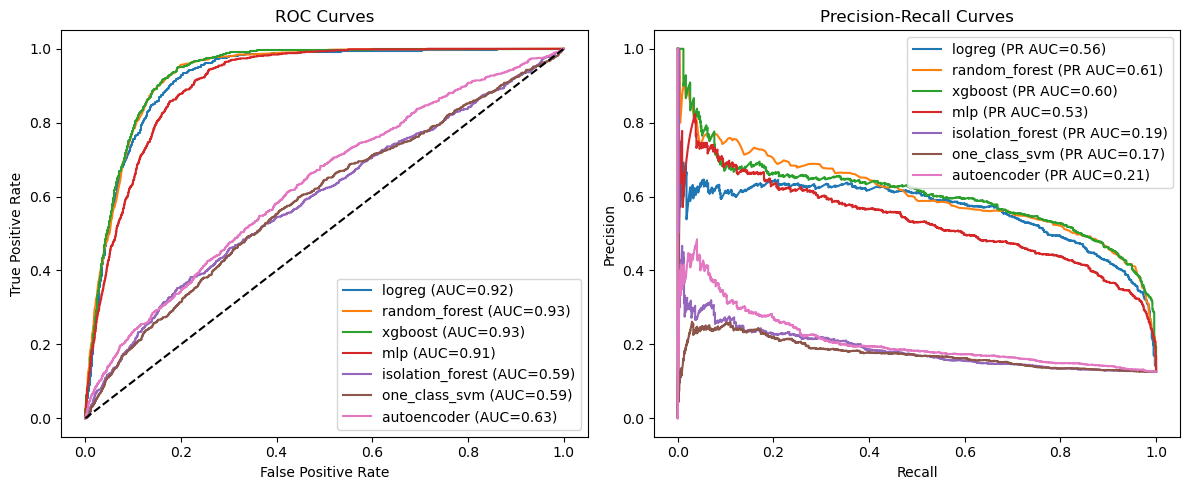

In [13]:

plt.figure(figsize=(12,5))

# ROC Curve
plt.subplot(1,2,1)
for name, model in models.items():
    if name in ["mlp", "autoencoder"]:
        y_proba = model.predict(X_test_scaled).ravel() if name == "mlp" else np.mean((X_test_scaled - model.predict(X_test_scaled))**2, axis=1)
    elif name in ["isolation_forest", "one_class_svm"]:
        y_proba = -model.decision_function(X_test_scaled)
    else:
        y_proba = model.predict_proba(X_test)[:,1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc_score(y_test, y_proba):.2f})")
plt.plot([0,1],[0,1],'k--')
plt.title("ROC Curves")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()

# PR Curve
plt.subplot(1,2,2)
for name, model in models.items():
    if name in ["mlp", "autoencoder"]:
        y_proba = model.predict(X_test_scaled).ravel() if name == "mlp" else np.mean((X_test_scaled - model.predict(X_test_scaled))**2, axis=1)
    elif name in ["isolation_forest", "one_class_svm"]:
        y_proba = -model.decision_function(X_test_scaled)
    else:
        y_proba = model.predict_proba(X_test)[:,1]
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    plt.plot(recall, precision, label=f"{name} (PR AUC={compute_pr_auc(y_test, y_proba):.2f})")
plt.title("Precision-Recall Curves")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()

plt.tight_layout()
plt.show()

## Let's create a DataFrame from results

In [14]:
# -----------------------------
results_df = pd.DataFrame(results).T  # transpose so models are rows

# Round metrics for readability
results_df = results_df.round(4)

# Reorder columns for clarity
results_df = results_df[["roc_auc", "pr_auc", "f1", "precision", "recall", "threshold"]]

# Print the table
print("📊 Model Metrics Comparison:\n")
print(results_df)

# Optional: highlight the best PR AUC
best_pr_model = results_df["pr_auc"].idxmax()
print(f"\n✅ Model with highest PR AUC: {best_pr_model} ({results_df.loc[best_pr_model,'pr_auc']:.4f})")


📊 Model Metrics Comparison:

                  roc_auc  pr_auc      f1  precision  recall  threshold
logreg             0.9235  0.5606  0.5931     0.4537  0.8562     0.5000
random_forest      0.9310  0.6066  0.5746     0.5807  0.5687     0.5000
xgboost            0.9334  0.6033  0.5844     0.5954  0.5738     0.5000
mlp                0.9078  0.5308  0.3995     0.2503  0.9883     0.0000
isolation_forest   0.5929  0.1883  0.2471     0.1549  0.6114    -0.0447
one_class_svm      0.5904  0.1746  0.2513     0.1575  0.6218   -26.2506
autoencoder        0.6289  0.2093  0.2686     0.1683  0.6645     0.0050

✅ Model with highest PR AUC: random_forest (0.6066)


#### PR AUC (Precision-Recall AUC)
- Focuses on positive class performance.
- Ideal when the dataset is imbalanced, i.e., the number of positive cases (subscribers/fraud) is much smaller than negative cases.
- Measures how well the model balances precision and recall across thresholds.
- Why it’s ideal here: In the bank marketing dataset or fraud detection, only a small fraction subscribe, so PR AUC gives a more realistic view of performance than accuracy.

#### ROC AUC (Receiver Operating Characteristic - secondary metric
- Measures the tradeoff between True Positive Rate and False Positive Rate.
- Can be misleading on highly imbalanced datasets because the negative class dominates.

In [26]:
results

{'logreg': {'roc_auc': 0.9235203867130173,
  'pr_auc': 0.5605809939590362,
  'f1': 0.5930910722296994,
  'precision': 0.45367192862045297,
  'recall': 0.8562176165803109,
  'threshold': 0.5},
 'random_forest': {'roc_auc': 0.9309668701315384,
  'pr_auc': 0.6066016078145933,
  'f1': 0.574607329842932,
  'precision': 0.5806878306878307,
  'recall': 0.5686528497409327,
  'threshold': 0.5},
 'xgboost': {'roc_auc': 0.9333908822304318,
  'pr_auc': 0.6033062857303141,
  'f1': 0.5844327176781002,
  'precision': 0.5954301075268817,
  'recall': 0.5738341968911918,
  'threshold': 0.5},
 'mlp': {'roc_auc': 0.907809927087429,
  'pr_auc': 0.5307514727056413,
  'f1': 0.3994764397905759,
  'precision': 0.2503280839895013,
  'recall': 0.9883419689119171,
  'threshold': np.float32(1.7751545e-05)},
 'isolation_forest': {'roc_auc': 0.5928733849651397,
  'pr_auc': 0.18833068526608568,
  'f1': 0.24712041884816754,
  'precision': 0.15485564304461943,
  'recall': 0.6113989637305699,
  'threshold': np.float64(-

## Hyperparameter Tuning - Optuna

In [15]:
def evaluate_model(model, X, y, threshold=0.5):
    y_proba = model.predict_proba(X)[:,1]
    y_pred = (y_proba >= threshold).astype(int)
    metrics = {
        "roc_auc": roc_auc_score(y, y_proba),
        "pr_auc": compute_pr_auc(y, y_proba),
        "f1": f1_score(y, y_pred),
        "precision": precision_score(y, y_pred),
        "recall": recall_score(y, y_pred),
        "threshold": threshold
    }
    return metrics


In [24]:
# -----------------------------
# Load data and results
# -----------------------------
data = joblib.load("artifacts/data_splits.pkl")
X_train, y_train = data["X_train"], data["y_train"]
X_val, y_val = data["X_val"], data["y_val"]
X_test, y_test = data["X_test"], data["y_test"]

###  Select top 2 models by PR AUC

In [16]:
sorted_models = sorted(results.items(), key=lambda x: x[1]["pr_auc"], reverse=True)
top2_models = [sorted_models[0][0], sorted_models[1][0]]
print("Top 2 models to tune:", top2_models)

Top 2 models to tune: ['random_forest', 'xgboost']


### Define Optuna objective functions

In [17]:
def rf_objective(trial):
    from sklearn.ensemble import RandomForestClassifier
    n_estimators = trial.suggest_int("n_estimators", 100, 500)
    max_depth = trial.suggest_int("max_depth", 3, 20)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
    
    rf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        class_weight="balanced",
        random_state=42,
        n_jobs=-1
    )
    
    rf.fit(X_train, y_train)
    y_val_proba = rf.predict_proba(X_val)[:,1]
    return compute_pr_auc(y_val, y_val_proba)



In [18]:
def xgb_objective(trial):
    from xgboost import XGBClassifier
    n_estimators = trial.suggest_int("n_estimators", 100, 500)
    max_depth = trial.suggest_int("max_depth", 3, 10)
    learning_rate = trial.suggest_float("learning_rate", 0.01, 0.3)
    gamma = trial.suggest_float("gamma", 0, 5)
    
    scale_pos_weight = (y_train==0).sum() / (y_train==1).sum()
    
    xgb = XGBClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        gamma=gamma,
        scale_pos_weight=scale_pos_weight,
        use_label_encoder=False,
        eval_metric="logloss",
        random_state=42,
        n_jobs=-1
    )
    xgb.fit(X_train, y_train)
    y_val_proba = xgb.predict_proba(X_val)[:,1]
    return compute_pr_auc(y_val, y_val_proba)

### Run Optuna tuning for top models

In [22]:
import optuna

In [28]:
tuned_models = {}
tuned_metrics = {}

if "random_forest" in top2_models:
    print("\n🔧 Tuning RandomForest...")
    study_rf = optuna.create_study(direction="maximize")
    study_rf.optimize(rf_objective, n_trials=20, show_progress_bar=True)
    best_rf_params = study_rf.best_params
    print("Best RF params:", best_rf_params)
    
    best_rf = RandomForestClassifier(**best_rf_params, class_weight="balanced", random_state=42, n_jobs=-1)
    best_rf.fit(X_train, y_train)
    tuned_models["random_forest"] = best_rf
    tuned_metrics["random_forest"] = evaluate_model(best_rf, X_test, y_test)

if "xgboost" in top2_models:
    print("\n🔧 Tuning XGBoost...")
    study_xgb = optuna.create_study(direction="maximize")
    study_xgb.optimize(xgb_objective, n_trials=20, show_progress_bar=True)
    best_xgb_params = study_xgb.best_params
    print("Best XGB params:", best_xgb_params)
    
    scale_pos_weight = (y_train==0).sum() / (y_train==1).sum()
    best_xgb = XGBClassifier(**best_xgb_params, scale_pos_weight=scale_pos_weight,
                             use_label_encoder=False, eval_metric="logloss", random_state=42, n_jobs=-1)
    best_xgb.fit(X_train, y_train)
    tuned_models["xgboost"] = best_xgb
    tuned_metrics["xgboost"] = evaluate_model(best_xgb, X_test, y_test)


[I 2026-01-20 20:30:35,521] A new study created in memory with name: no-name-870ce332-4783-4a27-8460-6720bb9726d8



🔧 Tuning RandomForest...


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2026-01-20 20:30:37,017] Trial 0 finished with value: 0.6248908138477364 and parameters: {'n_estimators': 239, 'max_depth': 6, 'min_samples_split': 5}. Best is trial 0 with value: 0.6248908138477364.
[I 2026-01-20 20:30:42,734] Trial 1 finished with value: 0.6558866783784096 and parameters: {'n_estimators': 495, 'max_depth': 20, 'min_samples_split': 9}. Best is trial 1 with value: 0.6558866783784096.
[I 2026-01-20 20:30:44,769] Trial 2 finished with value: 0.6584596992625248 and parameters: {'n_estimators': 197, 'max_depth': 13, 'min_samples_split': 5}. Best is trial 2 with value: 0.6584596992625248.
[I 2026-01-20 20:30:48,933] Trial 3 finished with value: 0.6564091624422262 and parameters: {'n_estimators': 356, 'max_depth': 17, 'min_samples_split': 2}. Best is trial 2 with value: 0.6584596992625248.
[I 2026-01-20 20:30:52,939] Trial 4 finished with value: 0.6520253511217095 and parameters: {'n_estimators': 346, 'max_depth': 17, 'min_samples_split': 3}. Best is trial 2 with value: 0

[I 2026-01-20 20:31:22,188] A new study created in memory with name: no-name-d52f3899-460c-4720-a0e6-cadf7480524a



🔧 Tuning XGBoost...


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2026-01-20 20:31:24,425] Trial 0 finished with value: 0.6837635772597458 and parameters: {'n_estimators': 466, 'max_depth': 8, 'learning_rate': 0.07023902741763201, 'gamma': 2.8391922628462503}. Best is trial 0 with value: 0.6837635772597458.
[I 2026-01-20 20:31:25,389] Trial 1 finished with value: 0.668889014298804 and parameters: {'n_estimators': 263, 'max_depth': 10, 'learning_rate': 0.2368935920773695, 'gamma': 4.391632102875222}. Best is trial 0 with value: 0.6837635772597458.
[I 2026-01-20 20:31:26,467] Trial 2 finished with value: 0.6844397127742368 and parameters: {'n_estimators': 410, 'max_depth': 3, 'learning_rate': 0.1539968146741605, 'gamma': 4.122880445172197}. Best is trial 2 with value: 0.6844397127742368.
[I 2026-01-20 20:31:27,449] Trial 3 finished with value: 0.6739779304725297 and parameters: {'n_estimators': 266, 'max_depth': 6, 'learning_rate': 0.22292275575234702, 'gamma': 2.8601992902715283}. Best is trial 2 with value: 0.6844397127742368.
[I 2026-01-20 20:31:

## Select final best model based on PR AUC

In [29]:
final_model_name = max(tuned_metrics, key=lambda k: tuned_metrics[k]["pr_auc"])
final_model_metrics = tuned_metrics[final_model_name]
final_model = tuned_models[final_model_name]

# Save final model
model_file = MODELS_DIR / ("best_model.pkl" if final_model_name in ["random_forest", "xgboost"] else "best_model.h5")
joblib.dump(final_model, model_file)

# Save metadata
metadata = {"model_name": final_model_name}
metadata.update(final_model_metrics)
with open(ARTIFACTS_DIR / "best_model.json", "w") as f:
    json.dump(metadata, f, indent=4)

# Print final results
print("\n✅ Final Best Model:", final_model_name)
print("Metrics on Test Data:")
for metric, value in final_model_metrics.items():
    print(f"  {metric}: {value:.4f}")


✅ Final Best Model: xgboost
Metrics on Test Data:
  roc_auc: 0.9379
  pr_auc: 0.6347
  f1: 0.6317
  precision: 0.5742
  recall: 0.7021
  threshold: 0.5000
